In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/train-data-original/train_data_sample.csv
/kaggle/input/all-project-files/train_data_sample_encoded (1).csv
/kaggle/input/all-project-files/final_xgb_model (1).pkl
/kaggle/input/all-project-files/final_nn_model (1).h5
/kaggle/input/all-project-files/xgb_grid_search_results (1).csv
/kaggle/input/all-project-files/nn_grid_search_results (1).csv
/kaggle/input/all-project-files/train_data_selected.csv
/kaggle/input/all-project-files/processed_nn_data (1).csv
/kaggle/input/final-xgb-model/final_xgb_model (2).pkl


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score
import xgboost as xgb
from tensorflow import keras
import shap
import time
import pickle
import plotly.graph_objects as go
import warnings
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

In [3]:
train_data_final = pd.read_csv('/kaggle/input/all-project-files/train_data_sample_encoded (1).csv')

In [10]:
features_imp = pd.read_csv('/kaggle/input/feature-imp/feature_importance.csv')

In [11]:
features_imp = features_imp.sort_values("Importance",ascending=[False])

<Axes: xlabel='Feature'>

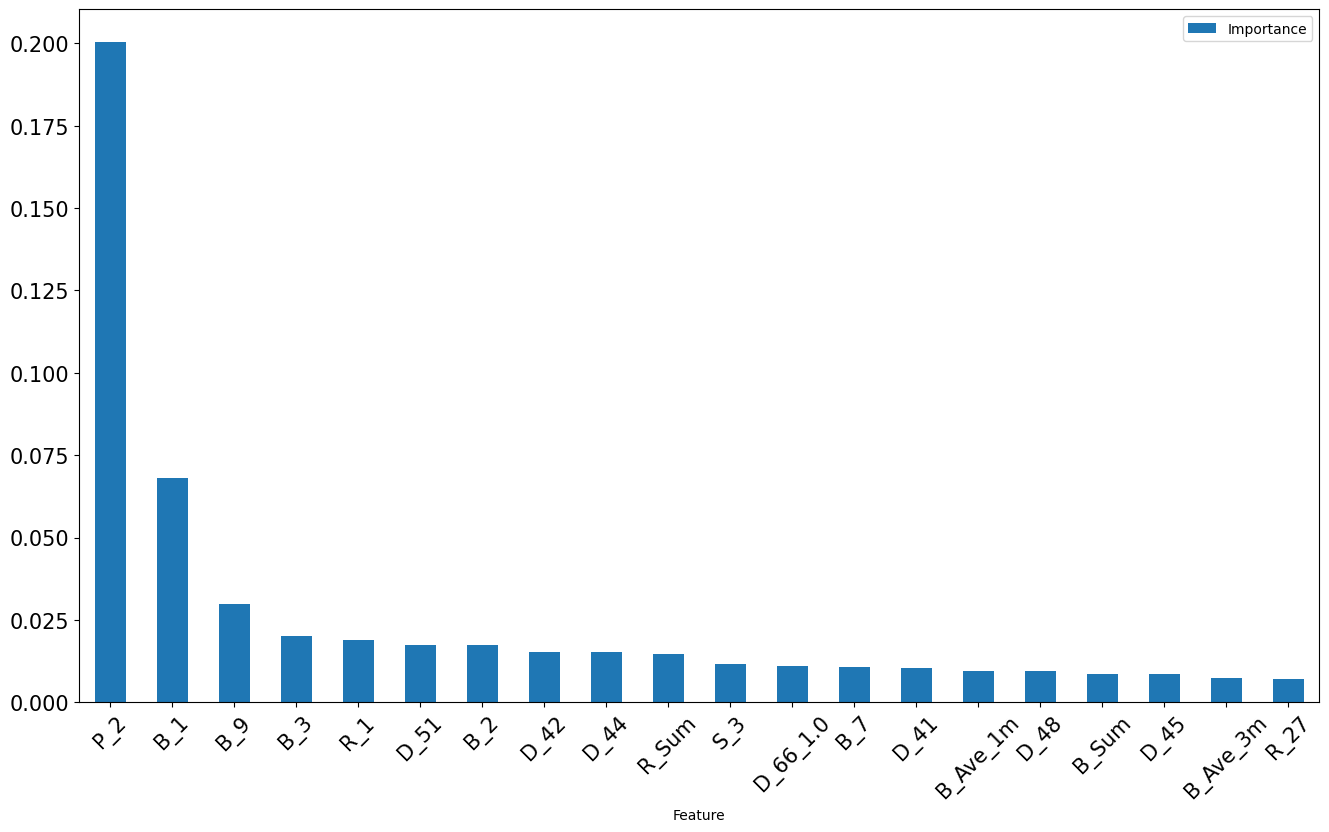

In [12]:
features_imp.head(20).plot(x='Feature', y='Importance', kind='bar', figsize=(16,9), rot=45, fontsize=15)

In [13]:
features_imp_2 = pd.read_csv('/kaggle/input/feature-importance/feature_importance_2.csv')

In [14]:
features_imp_2 = features_imp_2.sort_values("Importance",ascending=[False])

<Axes: xlabel='Feature'>

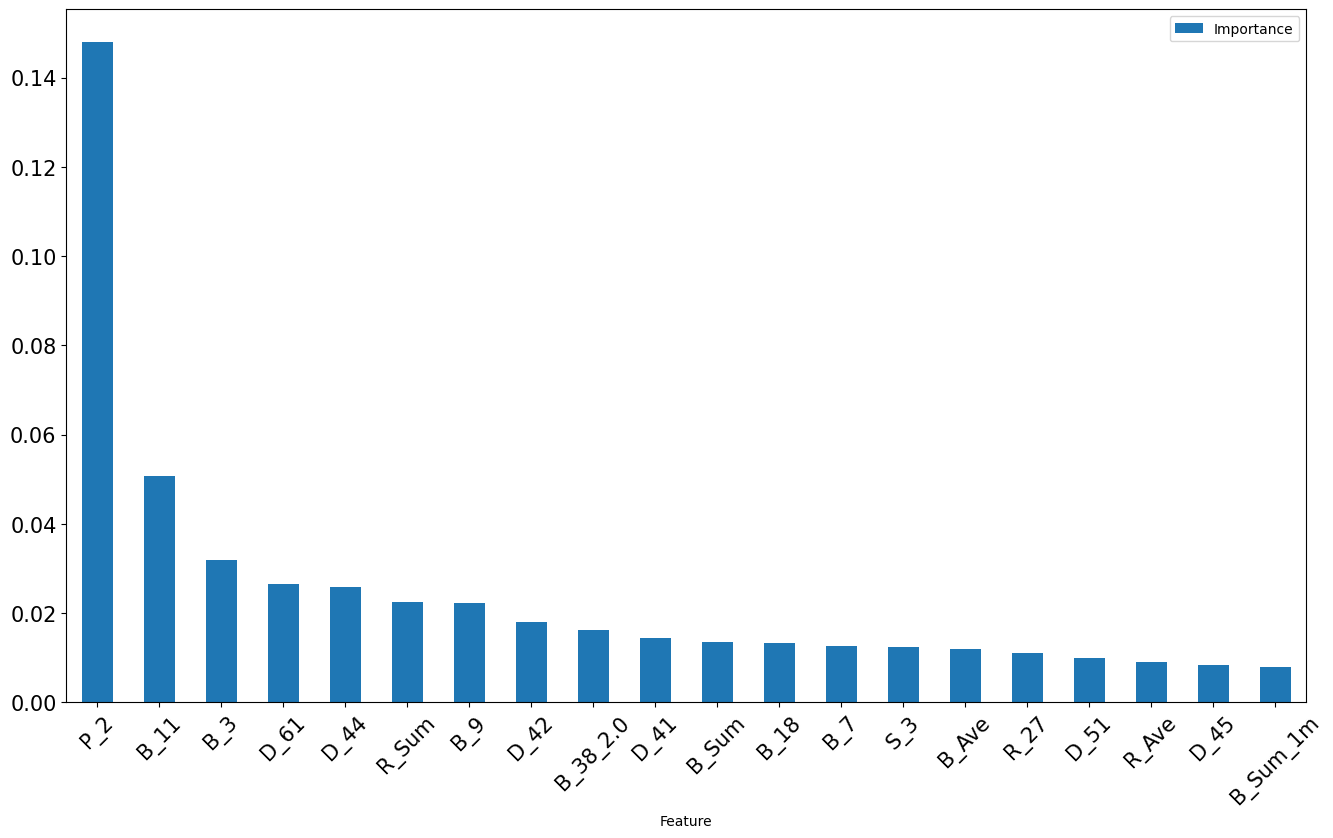

In [15]:
features_imp_2.head(20).plot(x='Feature', y='Importance', kind='bar', figsize=(16,9), rot=45, fontsize=15)

In [4]:
train_data_final = train_data_final.drop(columns=['customer_ID','S_2'])

In [5]:
print(train_data_final.isnull().sum())

P_2                             9326
D_39                               0
B_1                                0
B_2                              367
R_1                                0
                              ...   
D_68_6.0_Ever_Response_12      77133
D_68_6.0_April_2018          1105022
D_68_nan_Response_Rate_6      571080
D_68_nan_Ever_Response_12      77133
D_68_nan_April_2018          1105022
Length: 437, dtype: int64


In [6]:
print(train_data_final.isna().sum())

P_2                             9326
D_39                               0
B_1                                0
B_2                              367
R_1                                0
                              ...   
D_68_6.0_Ever_Response_12      77133
D_68_6.0_April_2018          1105022
D_68_nan_Response_Rate_6      571080
D_68_nan_Ever_Response_12      77133
D_68_nan_April_2018          1105022
Length: 437, dtype: int64


In [7]:
all_nan_cols = train_data_final.columns[train_data_final.isnull().all()]
print("All NaN columns:", all_nan_cols.tolist())

train_data_final.drop(columns=all_nan_cols, inplace=True)

All NaN columns: ['B_30_0.0_April_2018', 'B_30_1.0_April_2018', 'B_30_2.0_April_2018', 'B_30_nan_April_2018', 'B_38_1.0_April_2018', 'B_38_2.0_April_2018', 'B_38_3.0_April_2018', 'B_38_4.0_April_2018', 'B_38_5.0_April_2018', 'B_38_6.0_April_2018', 'B_38_7.0_April_2018', 'B_38_nan_April_2018', 'D_114_0.0_April_2018', 'D_114_1.0_April_2018', 'D_114_nan_April_2018', 'D_116_0.0_April_2018', 'D_116_1.0_April_2018', 'D_116_nan_April_2018', 'D_117_-1.0_April_2018', 'D_117_1.0_April_2018', 'D_117_2.0_April_2018', 'D_117_3.0_April_2018', 'D_117_4.0_April_2018', 'D_117_5.0_April_2018', 'D_117_6.0_April_2018', 'D_117_nan_April_2018', 'D_120_0.0_April_2018', 'D_120_1.0_April_2018', 'D_120_nan_April_2018', 'D_126_-1.0_April_2018', 'D_126_0.0_April_2018', 'D_126_1.0_April_2018', 'D_126_nan_April_2018', 'D_63_CL_April_2018', 'D_63_CO_April_2018', 'D_63_CR_April_2018', 'D_63_XL_April_2018', 'D_63_XM_April_2018', 'D_63_XZ_April_2018', 'D_64_-1_April_2018', 'D_64_O_April_2018', 'D_64_R_April_2018', 'D_6

In [8]:
for col in train_data_final.columns:
    if train_data_final[col].nunique() > 2:
        # Likely a continuous/numerical feature
        train_data_final[col].fillna(train_data_final[col].median(), inplace=True)
    else:
        # Likely a binary column from one-hot encoding
        train_data_final[col].fillna(0, inplace=True)

In [9]:
print(train_data_final.isnull().sum().sum())  # Should be 0

0


In [10]:
pre_proc_data = train_data_final.copy()

In [11]:
print(pre_proc_data.columns)

Index(['P_2', 'D_39', 'B_1', 'B_2', 'R_1', 'S_3', 'D_41', 'B_3', 'D_42',
       'D_43',
       ...
       'D_68_3.0_Response_Rate_6', 'D_68_3.0_Ever_Response_12',
       'D_68_4.0_Response_Rate_6', 'D_68_4.0_Ever_Response_12',
       'D_68_5.0_Response_Rate_6', 'D_68_5.0_Ever_Response_12',
       'D_68_6.0_Response_Rate_6', 'D_68_6.0_Ever_Response_12',
       'D_68_nan_Response_Rate_6', 'D_68_nan_Ever_Response_12'],
      dtype='object', length=382)


In [12]:
selected_features = pd.read_csv('/kaggle/input/all-project-files/train_data_selected.csv')
selected_features = selected_features.drop(columns=['customer_ID','S_2','target'])

In [13]:
selected_cols = list(selected_features.columns)
print(selected_cols)

['P_2', 'D_39', 'B_1', 'B_2', 'R_1', 'S_3', 'D_41', 'B_3', 'D_42', 'D_43', 'D_44', 'D_45', 'D_46', 'D_48', 'D_49', 'B_7', 'D_51', 'B_9', 'R_3', 'B_10', 'S_7', 'D_55', 'D_62', 'B_19', 'D_79', 'B_33', 'S_23', 'R_27', 'D_112', 'D_132', 'B_38_2.0', 'B_38_4.0', 'D_66_1.0', 'B_Sum', 'R_Sum', 'P_Ave', 'B_Ave', 'B_Ave_1m', 'B_Ave_3m', 'R_Sum_3m', 'B_Sum_1m', 'B_Sum_3m', 'B_Sum_6m', 'B_30_1.0_Response_Rate_6', 'B_38_2.0_Ever_Response_12', 'D_63_CO_Response_Rate_6', 'D_64_O_Ever_Response_12']


In [20]:
xgb_best = pickle.load(open("/kaggle/input/final-xgb-model/final_xgb_model (2).pkl", "rb"))

In [15]:
xgb_pred = xgb_best.predict_proba(pre_proc_data[selected_cols])

# Stretegy PART

In [16]:
input_data = pd.DataFrame()
input_data["pred"] = pd.Series(list(xgb_pred[:, 1]))
input_data["target"] = pre_proc_data["target"]
input_data["bal"] = pre_proc_data["B_Ave"]
input_data["spend"] = pre_proc_data["S_Ave"]

In [71]:
def strategy(data,target,model_pred,bal,spend,threshold):
    accepted  = data[data[model_pred]<threshold]
    d_rate = accepted[target].mean()
    non_defaulted = accepted[accepted[target]==0]
    rev = (non_defaulted[bal]*0.02+ non_defaulted[spend]*0.001)*12 
    acceptance_per = (data["pred"] < threshold).mean()*100
    return (acceptance_per, accepted[target].mean(),rev.sum())

In [106]:
output = pd.DataFrame(columns=["Treshold","Default rate","Revenue","% Accepted"])
j = 0
for i in tqdm(range(1,100)):
    acceptance_per,dr,r = strategy(input_data,"target","pred","bal","spend",i/10)
    output.loc[j] = [i/10,dr,r,acceptance_per]
    j = j+1

100%|██████████| 99/99 [00:02<00:00, 34.89it/s]


In [107]:
output.head()

,Treshold,Default rate,Revenue,% Accepted
0,0.1,0.011441,25420.070204,53.637394
1,0.2,0.023761,28965.555254,61.048377
2,0.3,0.037733,31174.858787,65.894163
3,0.4,0.055231,32998.001941,70.257334
4,0.5,0.077162,34635.779913,74.702676


In [75]:
output = output[output["Default rate"]<=0.1]

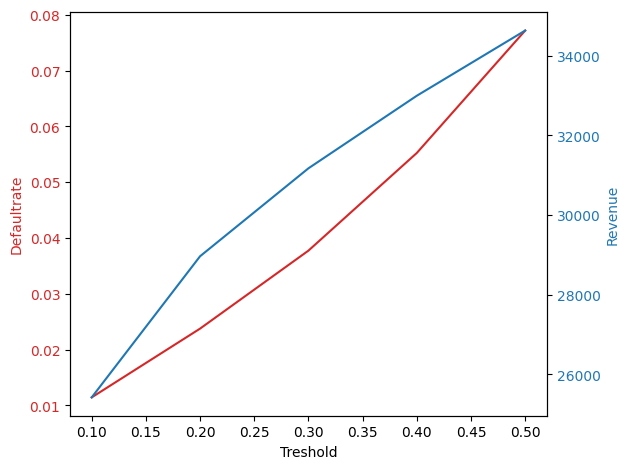

In [76]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Treshold')
ax1.set_ylabel('Defaultrate', color=color)
ax1.plot(output["Treshold"], output["Default rate"], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Revenue', color=color)  # we already handled the x-label with ax1
ax2.plot(output["Treshold"], output["Revenue"], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [77]:
output

,Treshold,Default rate,Revenue
0,0.1,0.011441,25420.070204
1,0.2,0.023761,28965.555254
2,0.3,0.037733,31174.858787
3,0.4,0.055231,32998.001941
4,0.5,0.077162,34635.779913


In [78]:
# Select a conservative and an aggressive strategy
conservative_strategy = output.iloc[0]  # Lowest threshold that meets constraints
aggressive_strategy = output.iloc[-1]  # Highest threshold under 10% default rate
print(conservative_strategy)

Treshold            0.100000
Default rate        0.011441
Revenue         25420.070204
Name: 0, dtype: float64


In [79]:
total_applicants = len(input_data)  # Assuming train_data contains all applicants
conservative_acceptance = (input_data["pred"] < conservative_strategy["Treshold"]).mean() * 100
aggressive_acceptance = (input_data["pred"] < aggressive_strategy["Treshold"]).mean() * 100

In [80]:
# Create summary table
strategy_table = pd.DataFrame({
    "Strategy": ["Conservative", "Aggressive"],
    "Threshold": [conservative_strategy["Treshold"], aggressive_strategy["Treshold"]],
    "Accepted Applicants %": [conservative_acceptance, aggressive_acceptance],
    "Default Rate": [conservative_strategy["Default rate"], aggressive_strategy["Default rate"]],
    "Expected Annual Revenue": [conservative_strategy["Revenue"], aggressive_strategy["Revenue"]]
})

In [81]:
strategy_table

,Strategy,Threshold,Accepted Applicants %,Default Rate,Expected Annual Revenue
0,Conservative,0.1,53.637394,0.011441,25420.070204
1,Aggressive,0.5,74.702676,0.077162,34635.779913


In [27]:
X_train, X_temp, y_train, y_temp = train_test_split(pre_proc_data.drop(columns=['target']), pre_proc_data["target"].values, test_size=0.3, random_state=14)

# Now, split X_temp and y_temp into test1 and test2
X_test1, X_test2, y_test1, y_test2 = train_test_split(X_temp, y_temp, test_size=0.5, random_state=14)

In [82]:
def make_table(data,tst,model):
    pred = model.predict_proba(data[selected_cols])
    input_data = pd.DataFrame()
    input_data["pred"] = pd.Series(list(pred[:, 1]))
    input_data["target"] = tst
    input_data["bal"] = data["B_Ave"]
    input_data["spend"] = data["S_Ave"]
    output = pd.DataFrame(columns=["Treshold","Default rate","Revenue","Accepted %"])
    j = 0
    for i in tqdm(range(1,11)):
        acceptance_per,dr,r = strategy(input_data,"target","pred","bal","spend",i/10)
        output.loc[j] = [i/10,dr,r,acceptance_per]
        j = j+1
    output["# Total"] = len(data)
    return output

In [83]:
def strategy_focused(data, target, model_pred, bal, spend, threshold):
    accepted = data[data[model_pred] < threshold]
    d_rate = accepted[target].mean()
    non_defaulted = accepted[accepted[target] == 0]
    rev = (non_defaulted[bal] * 0.02 + non_defaulted[spend] * 0.001) * 12
    acceptance_per = (data["pred"] < threshold).mean()*100
    return (acceptance_per, accepted[target].mean(), rev.sum())

def make_table_focused(data, tst, model):
    pred = model.predict_proba(data[selected_cols])
    input_data = pd.DataFrame()
    input_data["pred"] = pd.Series(list(pred[:, 1]))
    input_data["target"] = tst
    input_data["bal"] = data["B_Ave"]
    input_data["spend"] = data["S_Ave"]
    output = pd.DataFrame(columns=["Threshold", "Default rate", "Revenue","Accepted"])
    
    # Loop through thresholds from 0.01 to 1.0 with increments of 0.01
    for threshold in tqdm(np.arange(0.5, 0.61, 0.01)):
        acceptance_per,d_rate, revenue = strategy_focused(input_data, "target", "pred", "bal", "spend", threshold)
        output = pd.concat([output, pd.DataFrame({"Threshold": [threshold], "Default rate": [d_rate], "Revenue": [revenue],"Accepted":[acceptance_per]})], ignore_index=True)
    
    output["# Total"] = len(data)
    return output


In [84]:
    train_table_focused = make_table_focused(X_train,y_train,xgb_best)
    train_table_focused

100%|██████████| 11/11 [00:00<00:00, 32.62it/s]


,Threshold,Default rate,Revenue,Accepted,# Total
0,0.50,0.076888,18706.813374,74.676768,773515
1,0.51,0.079207,18772.096737,75.123042,773515
2,0.52,0.081622,18835.099130,75.570480,773515
3,0.53,0.084223,18895.376663,76.030458,773515
4,0.54,0.086756,18955.623350,76.486687,773515
5,0.55,0.089365,19016.087964,76.949898,773515
6,0.56,0.091968,19073.942544,77.410522,773515
7,0.57,0.094643,19128.898381,77.872569,773515
8,0.58,0.097500,19185.660931,78.354007,773515
9,0.59,0.100422,19243.118431,78.836739,773515


In [85]:
test1_table_focused = make_table_focused(X_test1,y_test1,xgb_best)
test1_table_focused

100%|██████████| 11/11 [00:00<00:00, 143.19it/s]


,Threshold,Default rate,Revenue,Accepted,# Total
0,0.50,0.078034,864.545318,74.746158,165753
1,0.51,0.080295,866.655369,75.181746,165753
2,0.52,0.082769,869.390371,75.631210,165753
3,0.53,0.085518,871.704267,76.113253,165753
4,0.54,0.088207,874.460872,76.590469,165753
5,0.55,0.091064,876.678492,77.069495,165753
6,0.56,0.093913,879.551843,77.532232,165753
7,0.57,0.096501,882.369347,77.997985,165753
8,0.58,0.099273,884.770224,78.487871,165753
9,0.59,0.102290,887.486793,78.998269,165753


In [86]:
test2_table_focused = make_table_focused(X_test2,y_test2,xgb_best)
test2_table_focused

100%|██████████| 11/11 [00:00<00:00, 95.51it/s]


,Threshold,Default rate,Revenue,Accepted,# Total
0,0.50,0.077571,870.193673,74.780096,165754
1,0.51,0.079756,872.983045,75.212665,165754
2,0.52,0.082287,875.803234,75.670572,165754
3,0.53,0.084932,878.143775,76.141149,165754
4,0.54,0.087622,880.773404,76.626808,165754
5,0.55,0.090324,883.925648,77.085923,165754
6,0.56,0.093115,886.687445,77.561326,165754
7,0.57,0.095797,889.784201,78.028886,165754
8,0.58,0.098604,892.800504,78.500066,165754
9,0.59,0.101475,895.022231,78.971850,165754


In [111]:
full_table_focused = pd.concat([train_table_focused.add_suffix('_Train'),
                        test1_table_focused.drop(columns=['Threshold']).add_suffix('_test1'),
                        test2_table_focused.drop(columns=['Threshold']).add_suffix('_test2')],axis=1)
full_table_focused

,Threshold_Train,Default rate_Train,Revenue_Train,Accepted_Train,# Total_Train,Default rate_test1,Revenue_test1,Accepted_test1,# Total_test1,Default rate_test2,Revenue_test2,Accepted_test2,# Total_test2
0,0.50,0.076888,18706.813374,74.676768,773515,0.078034,864.545318,74.746158,165753,0.077571,870.193673,74.780096,165754
1,0.51,0.079207,18772.096737,75.123042,773515,0.080295,866.655369,75.181746,165753,0.079756,872.983045,75.212665,165754
2,0.52,0.081622,18835.099130,75.570480,773515,0.082769,869.390371,75.631210,165753,0.082287,875.803234,75.670572,165754
3,0.53,0.084223,18895.376663,76.030458,773515,0.085518,871.704267,76.113253,165753,0.084932,878.143775,76.141149,165754
4,0.54,0.086756,18955.623350,76.486687,773515,0.088207,874.460872,76.590469,165753,0.087622,880.773404,76.626808,165754
5,0.55,0.089365,19016.087964,76.949898,773515,0.091064,876.678492,77.069495,165753,0.090324,883.925648,77.085923,165754
6,0.56,0.091968,19073.942544,77.410522,773515,0.093913,879.551843,77.532232,165753,0.093115,886.687445,77.561326,165754
7,0.57,0.094643,19128.898381,77.872569,773515,0.096501,882.369347,77.997985,165753,0.095797,889.784201,78.028886,165754
8,0.58,0.097500,19185.660931,78.354007,773515,0.099273,884.770224,78.487871,165753,0.098604,892.800504,78.500066,165754
9,0.59,0.100422,19243.118431,78.836739,773515,0.102290,887.486793,78.998269,165753,0.101475,895.022231,78.971850,165754


In [88]:
train_table_focused = make_table_focused(X_train,y_train,xgb_best)
test1_table_focused = make_table_focused(X_test1,y_test1,xgb_best)
test2_table_focused = make_table_focused(X_test2,y_test2,xgb_best)
train_table_focused
test2_table_focused
test1_table_focused



100%|██████████| 11/11 [00:00<00:00, 134.64it/s]


,Threshold,Default rate,Revenue,Accepted,# Total
0,0.50,0.078034,864.545318,74.746158,165753
1,0.51,0.080295,866.655369,75.181746,165753
2,0.52,0.082769,869.390371,75.631210,165753
3,0.53,0.085518,871.704267,76.113253,165753
4,0.54,0.088207,874.460872,76.590469,165753
5,0.55,0.091064,876.678492,77.069495,165753
6,0.56,0.093913,879.551843,77.532232,165753
7,0.57,0.096501,882.369347,77.997985,165753
8,0.58,0.099273,884.770224,78.487871,165753
9,0.59,0.102290,887.486793,78.998269,165753


In [89]:
train_table = make_table(X_train,y_train,xgb_best)
train_table

100%|██████████| 10/10 [00:00<00:00, 33.06it/s]


,Treshold,Default rate,Revenue,Accepted %,# Total
0,0.1,0.011477,14372.947652,53.615767,773515
1,0.2,0.023669,16159.460841,61.020536,773515
2,0.3,0.037577,17201.200152,65.858839,773515
3,0.4,0.055169,18007.639372,70.239103,773515
4,0.5,0.076888,18706.813374,74.676768,773515
5,0.6,0.103309,19298.411220,79.321927,773515
6,0.7,0.135930,19787.523007,84.384660,773515
7,0.8,0.173710,20147.121957,89.855788,773515
8,0.9,0.213584,20354.951015,95.376560,773515
9,1.0,0.247915,20411.136908,100.000000,773515


In [90]:
test1_table = make_table(X_test1,y_test1,xgb_best)
test1_table

100%|██████████| 10/10 [00:00<00:00, 128.99it/s]


,Treshold,Default rate,Revenue,Accepted %,# Total
0,0.1,0.011530,666.389784,53.736584,165753
1,0.2,0.024167,749.103507,61.112619,165753
2,0.3,0.038181,797.272568,65.954161,165753
3,0.4,0.055730,832.956362,70.279271,165753
4,0.5,0.078034,864.545318,74.746158,165753
5,0.6,0.105192,889.426586,79.479708,165753
6,0.7,0.137576,910.431514,84.490778,165753
7,0.8,0.175287,927.583616,89.914511,165753
8,0.9,0.214869,937.009383,95.361170,165753
9,1.0,0.249256,939.257599,100.000000,165753


In [91]:
test2_table = make_table(X_test2,y_test2,xgb_best)
test2_table

100%|██████████| 10/10 [00:00<00:00, 122.58it/s]


,Treshold,Default rate,Revenue,Accepted %,# Total
0,0.1,0.011180,665.692739,53.639128,165754
1,0.2,0.023781,748.796015,61.114061,165754
2,0.3,0.038009,798.474148,65.999011,165754
3,0.4,0.055019,835.058405,70.320475,165754
4,0.5,0.077571,870.193673,74.780096,165754
5,0.6,0.104226,897.559332,79.428551,165754
6,0.7,0.136820,920.739984,84.494492,165754
7,0.8,0.173746,936.055894,89.871134,165754
8,0.9,0.213072,946.001449,95.306901,165754
9,1.0,0.247904,948.244464,100.000000,165754


In [92]:
full_table = pd.concat([train_table.add_suffix('_Train'),
                        test1_table.drop(columns =["Treshold"]).add_suffix('_test1'),
                        test2_table.drop(columns =["Treshold"]).add_suffix('_test2')],axis=1)
full_table

,Treshold_Train,Default rate_Train,Revenue_Train,Accepted %_Train,# Total_Train,Default rate_test1,Revenue_test1,Accepted %_test1,# Total_test1,Default rate_test2,Revenue_test2,Accepted %_test2,# Total_test2
0,0.1,0.011477,14372.947652,53.615767,773515,0.011530,666.389784,53.736584,165753,0.011180,665.692739,53.639128,165754
1,0.2,0.023669,16159.460841,61.020536,773515,0.024167,749.103507,61.112619,165753,0.023781,748.796015,61.114061,165754
2,0.3,0.037577,17201.200152,65.858839,773515,0.038181,797.272568,65.954161,165753,0.038009,798.474148,65.999011,165754
3,0.4,0.055169,18007.639372,70.239103,773515,0.055730,832.956362,70.279271,165753,0.055019,835.058405,70.320475,165754
4,0.5,0.076888,18706.813374,74.676768,773515,0.078034,864.545318,74.746158,165753,0.077571,870.193673,74.780096,165754
5,0.6,0.103309,19298.411220,79.321927,773515,0.105192,889.426586,79.479708,165753,0.104226,897.559332,79.428551,165754
6,0.7,0.135930,19787.523007,84.384660,773515,0.137576,910.431514,84.490778,165753,0.136820,920.739984,84.494492,165754
7,0.8,0.173710,20147.121957,89.855788,773515,0.175287,927.583616,89.914511,165753,0.173746,936.055894,89.871134,165754
8,0.9,0.213584,20354.951015,95.376560,773515,0.214869,937.009383,95.361170,165753,0.213072,946.001449,95.306901,165754
9,1.0,0.247915,20411.136908,100.000000,773515,0.249256,939.257599,100.000000,165753,0.247904,948.244464,100.000000,165754


# Slide 1

In [94]:
# Load grid search results
results_xgb = pd.read_csv('/kaggle/input/all-project-files/xgb_grid_search_results (1).csv')
results_xgb['Bias'] = results_xgb['AUC Train'] - (results_xgb['AUC Test 1'] + results_xgb['AUC Test 2']) / 2
results_xgb['Variance'] = abs(results_xgb['AUC Test 1'] - results_xgb['AUC Test 2'])

In [95]:
results_xgb["Average AUC"] = results_xgb[["AUC Train","AUC Test 1","AUC Test 2"]].mean(axis=1)
results_xgb["Std AUC"] = results_xgb[["AUC Train","AUC Test 1","AUC Test 2"]].std(axis=1)

In [96]:
full_table[(full_table["Treshold_Train"]==0.2)|(full_table["Treshold_Train"]==0.5)]

,Treshold_Train,Default rate_Train,Revenue_Train,# Total_Train,Default rate_test1,Revenue_test1,# Total_test1,Default rate_test2,Revenue_test2,# Total_test2
1,0.2,0.023669,16159.460841,773515,0.024167,749.103507,165753,0.023781,748.796015,165754
4,0.5,0.076888,18706.813374,773515,0.078034,864.545318,165753,0.077571,870.193673,165754


In [97]:
results_xgb.sort_values(by=["Average AUC"]).tail()

,# Trees,LR,Subsample,% Features,Weight of Default,AUC Train,AUC Test 1,AUC Test 2,Bias,Variance,Average AUC,Std AUC
71,300,0.1,0.8,1.0,10,0.950947,0.941685,0.940309,0.009950,0.001376,0.944314,0.005786
66,300,0.1,0.8,0.5,1,0.950735,0.942310,0.940764,0.009198,0.001546,0.944603,0.005366
63,300,0.1,0.5,1.0,1,0.951768,0.942558,0.940866,0.010056,0.001691,0.945064,0.005867
70,300,0.1,0.8,1.0,5,0.951846,0.942288,0.941092,0.010156,0.001197,0.945075,0.005894
69,300,0.1,0.8,1.0,1,0.952671,0.943099,0.941654,0.010294,0.001445,0.945808,0.005987


# Model Selection

In [95]:
# Load grid search results
results_xgb = pd.read_csv('/kaggle/input/all-project-files/xgb_grid_search_results (1).csv')
results_xgb['Bias'] = results_xgb['AUC Train'] - (results_xgb['AUC Test 1'] + results_xgb['AUC Test 2']) / 2
results_xgb['Variance'] = abs(results_xgb['AUC Test 1'] - results_xgb['AUC Test 2'])

In [98]:
results_xgb.sort_values(by=['AUC Test 1','AUC Test 2','Bias', 'Variance'], ascending=[True,True,False,False]).iloc[66]

# Trees              300.000000
LR                     0.100000
Subsample              0.800000
% Features             1.000000
Weight of Default     10.000000
AUC Train              0.950947
AUC Test 1             0.941685
AUC Test 2             0.940309
Bias                   0.009950
Variance               0.001376
Name: 71, dtype: float64

In [100]:
results_xgb["Average AUC"] = results_xgb[["AUC Train","AUC Test 1","AUC Test 2"]].mean(axis=1)
results_xgb["Std AUC"] = results_xgb[["AUC Train","AUC Test 1","AUC Test 2"]].std(axis=1)

In [101]:
results_xgb["overfit_metric"] =(100*(1-results_xgb["Average AUC"]))**2 + ((results_xgb["AUC Train"]-results_xgb["AUC Test 1"])+
                                    (results_xgb["AUC Train"]-results_xgb["AUC Test 2"]))/results_xgb["Average AUC"]

In [104]:
results_xgb.sort_values(by=['overfit_metric','AUC Test 1','AUC Test 2','Bias', 'Variance'], ascending=[True,True,True,False,False]).head()

,# Trees,LR,Subsample,% Features,Weight of Default,AUC Train,AUC Test 1,AUC Test 2,Bias,Variance,Average AUC,Std AUC,overfit_metric
69,300,0.1,0.8,1.0,1,0.952671,0.943099,0.941654,0.010294,0.001445,0.945808,0.005987,29.389240
70,300,0.1,0.8,1.0,5,0.951846,0.942288,0.941092,0.010156,0.001197,0.945075,0.005894,30.188666
63,300,0.1,0.5,1.0,1,0.951768,0.942558,0.940866,0.010056,0.001691,0.945064,0.005867,30.201077
66,300,0.1,0.8,0.5,1,0.950735,0.942310,0.940764,0.009198,0.001546,0.944603,0.005366,30.707689
71,300,0.1,0.8,1.0,10,0.950947,0.941685,0.940309,0.009950,0.001376,0.944314,0.005786,31.030819


In [53]:
# Extract the best parameters
best_params = {
    'n_estimators': 300,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.5,
    'scale_pos_weight': 1,
}

In [17]:
train_data_selected = pd.read_csv('/kaggle/input/all-project-files/train_data_selected.csv')

In [56]:
# Prepare final dataset
X_final = train_data_selected.drop(['customer_ID', 'S_2', 'target'], axis=1)
y_final = train_data_selected['target']

# Train the final model with the best hyperparameters
final_model = xgb.XGBClassifier(**best_params)
final_model.fit(X_final, y_final)

# Save the final trained model
joblib.dump(final_model, "final_xgb_model.pkl")

print("Final model trained and saved as 'final_xgb_model.pkl'")

Final model trained and saved as 'final_xgb_model.pkl'


In [103]:
grid_results = pd.read_csv('/kaggle/input/all-project-files/xgb_grid_search_results (1).csv')
grid_results["Average AUC"] = grid_results[["AUC Train","AUC Test 1","AUC Test 2"]].mean(axis=1)
grid_results["Std AUC"] = grid_results[["AUC Train","AUC Test 1","AUC Test 2"]].std(axis=1)

In [93]:
# Load grid search results
results_xgb = pd.read_csv("/kaggle/input/all-project-files/xgb_grid_search_results (1).csv")
results_xgb['Bias'] = results_xgb['AUC Train'] - (results_xgb['AUC Test 1'] + results_xgb['AUC Test 2']) / 2
results_xgb['Variance'] = abs(results_xgb['AUC Test 1'] - results_xgb['AUC Test 2'])

In [94]:
best_xgb_model = results_xgb.sort_values(by=['Bias', 'Variance']).iloc[0]
print("Best Model Based on Bias and Variance:")
print(best_xgb_model)

Best Model Based on Bias and Variance:
# Trees              50.000000
LR                    0.010000
Subsample             0.500000
% Features            0.500000
Weight of Default    10.000000
AUC Train             0.926471
AUC Test 1            0.926884
AUC Test 2            0.925550
Bias                  0.000254
Variance              0.001334
Name: 2, dtype: float64


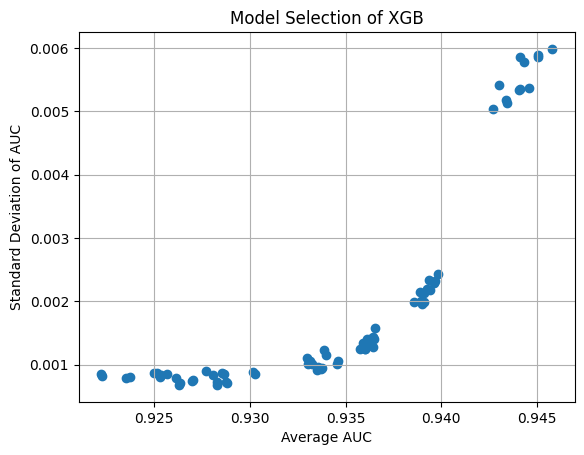

In [104]:
plt.scatter(grid_results["Average AUC"], grid_results["Std AUC"])
plt.grid(True)
plt.xlabel('Average AUC')
plt.ylabel('Standard Deviation of AUC')
plt.title('Model Selection of XGB')
plt.show()# slide 8a

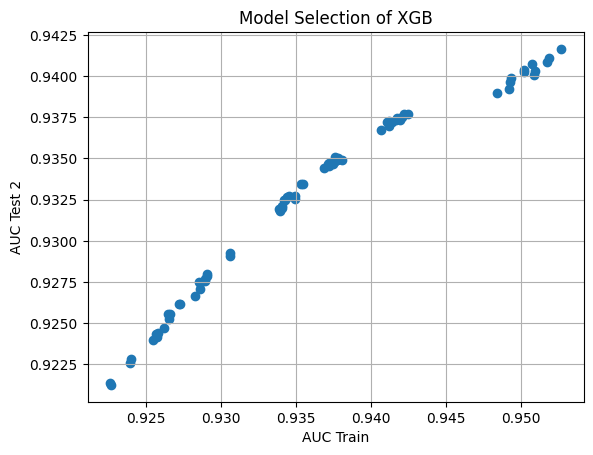

In [105]:
grid_results.sort_values(by=["Std AUC"])
x = grid_results.sort_values(by=["Std AUC"]).reset_index()
x[x["index"]==45]


plt.scatter(grid_results["AUC Train"], grid_results["AUC Test 2"])
plt.grid(True)
plt.xlabel('AUC Train')
plt.ylabel('AUC Test 2')
plt.title('Model Selection of XGB')
plt.show()# slide 8b

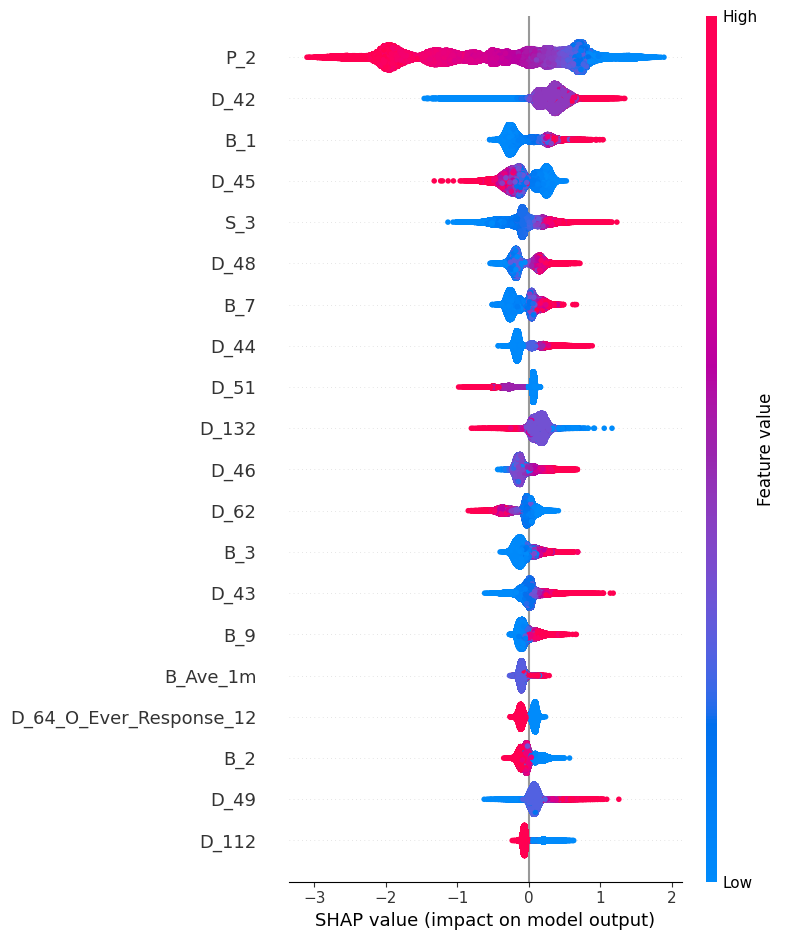

In [114]:
# Compute SHAP values from the best XGBoost model
explainer = shap.TreeExplainer(final_model) 
X_test2 = X_test2[xgb_best.get_booster().feature_names]
shap_values = explainer.shap_values(X_test2)
shap.summary_plot(shap_values, X_test2) 
plt.show()

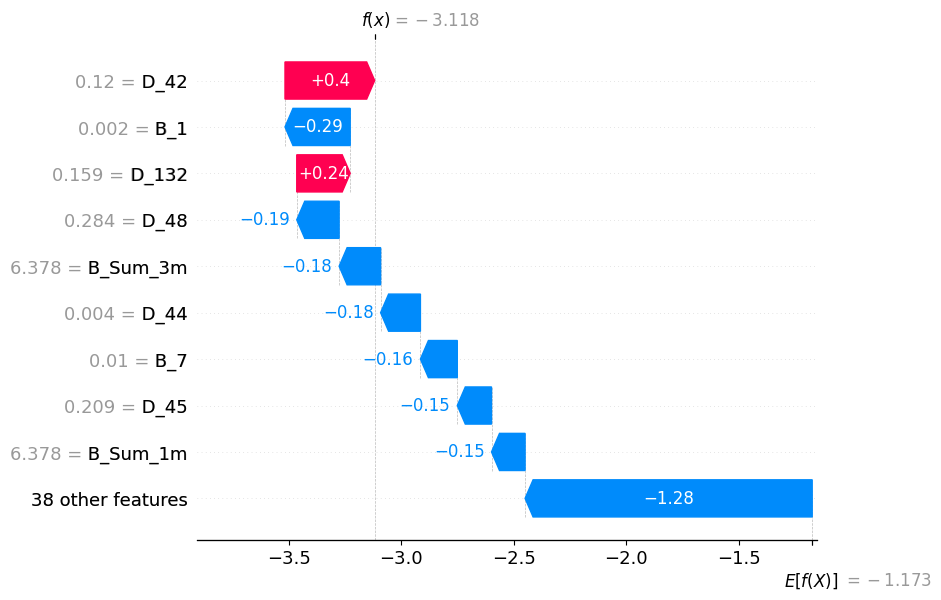

In [115]:
sample_index = 10  # Replace with the index of the sample you want to explain

# Create the Explanation object
explanation = shap.Explanation(values=shap_values[sample_index],
                                base_values=explainer.expected_value,
                                data=X_test2.iloc[sample_index],
                                feature_names=X_test2.columns.tolist())

# Generate the waterfall plot
shap.plots.waterfall(explanation)

In [116]:
shap_importance_1 = np.abs(shap_values).mean(axis=0)
shap_feature_importance_1 = pd.DataFrame({
    "Feature": X_test2.columns,
    "Mean SHAP Value": shap_importance_1
}).sort_values(by="Mean SHAP Value", ascending=False)
top_5_features = shap_feature_importance_1.head(5)["Feature"].tolist()

summary_stats = X_train[top_5_features].describe()

In [117]:
top_5_features

['P_2', 'D_42', 'B_1', 'D_45', 'S_3']

In [118]:
# Define the features of interest
top5_features = ["P_2", "D_42", "B_1", "D_45", "S_3"]

# Function to compute required statistics
def compute_feature_stats(df, feature_list):
    stats = df[feature_list].agg([
        "min",
        "max",
        lambda x: x.quantile(0.01),  # 1st percentile
        lambda x: x.quantile(0.05),  # 5th percentile
        "median",
        lambda x: x.quantile(0.95),  # 95th percentile
        lambda x: x.quantile(0.99),  # 99th percentile
        "mean"
    ]).T
    stats.columns = ["Min", "Max", "1%", "5%", "Median", "95%", "99%", "Mean"]

    # Compute % Missing values
    stats["% Missing"] = df[feature_list].isnull().mean() * 100
    
    return stats

# Compute stats for both test sets
stats = compute_feature_stats(X_train, top5_features)

stats


,Min,Max,1%,5%,Median,95%,99%,Mean,% Missing
P_2,-3.900031e-01,1.010000,0.007788,0.222997,0.694357,0.976395,1.005796,0.656792,0.0
D_42,-3.041203e-04,4.189044,0.008268,0.066526,0.119965,0.187505,0.501217,0.129140,0.0
B_1,-7.588799e+00,1.324052,0.000492,0.002137,0.031203,0.602984,1.008590,0.123897,0.0
D_45,7.454545e-08,1.596861,0.004747,0.012672,0.180870,0.768419,1.002751,0.251391,0.0
S_3,-4.915387e-01,3.379019,0.011630,0.069153,0.163986,0.555398,0.948952,0.214038,0.0


In [18]:
# Split the dataset into train and two test sets
X = train_data_selected.drop(['customer_ID', 'S_2', 'target'], axis=1)
y = train_data_selected['target']

X_train, X_test1, y_train, y_test1 = train_test_split(X, y, test_size=0.3, random_state=42)
X_test1, X_test2, y_test1, y_test2 = train_test_split(X_test1, y_test1, test_size=0.5, random_state=42)

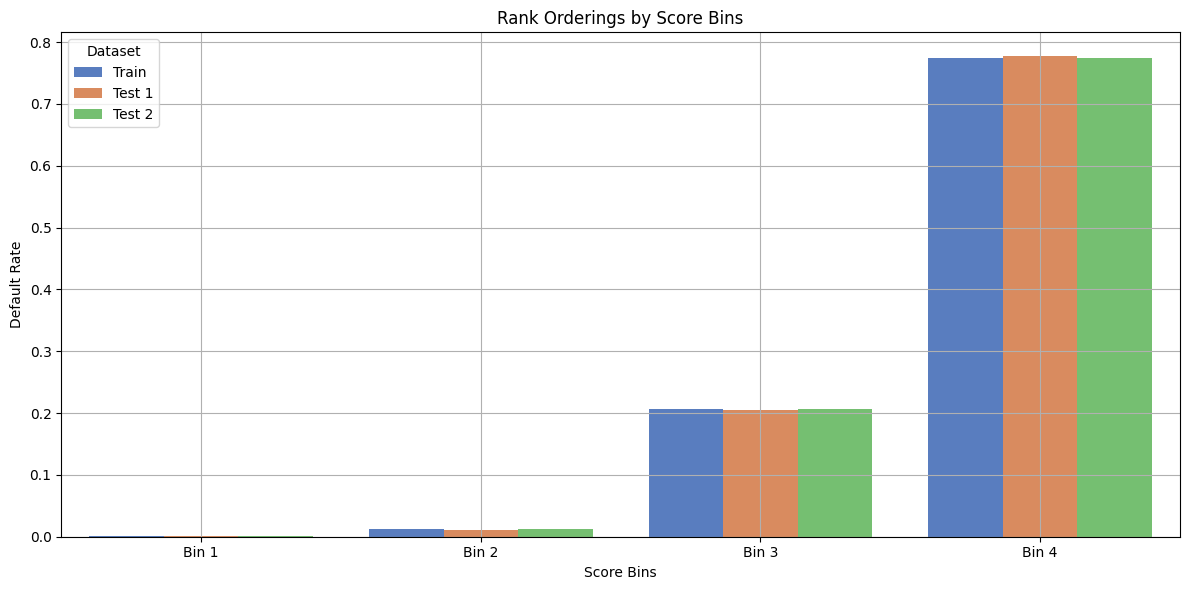

In [21]:
# Define score bins based on the train sample
train_scores = xgb_best.predict_proba(X_train)[:, 1]
bins = np.percentile(train_scores, [0, 25, 50, 75, 100])

# Apply the same thresholds to test samples
test1_scores = xgb_best.predict_proba(X_test1)[:, 1]
test2_scores = xgb_best.predict_proba(X_test2)[:, 1]

# Calculate default rates in each bin for each sample
def calculate_default_rate(scores, y):
    default_rates = []
    for i in range(len(bins) - 1):
        mask = (scores >= bins[i]) & (scores <= bins[i + 1])
        if np.sum(mask) > 0:
            default_rate = np.sum(y[mask]) / np.sum(mask)
            default_rates.append(default_rate)
        else:
            default_rates.append(0.0)
    return default_rates

default_rates_train = calculate_default_rate(train_scores, y_train)
default_rates_test1 = calculate_default_rate(test1_scores, y_test1)
default_rates_test2 = calculate_default_rate(test2_scores, y_test2)

df = pd.DataFrame({
    'Score Bins': [f"Bin {i+1}" for i in range(len(bins) - 1)],
    'Train': default_rates_train,
    'Test 1': default_rates_test1,
    'Test 2': default_rates_test2
})

# Melt DataFrame for better visualization
df_melted = df.melt(id_vars='Score Bins', var_name='Dataset', value_name='Default Rate')

# Plot using seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x='Score Bins', y='Default Rate', hue='Dataset', data=df_melted, palette='muted')
plt.xlabel('Score Bins')
plt.ylabel('Default Rate')
plt.title('Rank Orderings by Score Bins')
plt.legend(title='Dataset')
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
# Define score bins based on the train sample
train_scores = xgb_best.predict_proba(X_train)[:, 1]
bins = np.percentile(train_scores, [0, 25, 50, 75, 100])

# Apply the same thresholds to test samples
test1_scores = xgb_best.predict_proba(X_test1)[:, 1]
test2_scores = xgb_best.predict_proba(X_test2)[:, 1]

# Calculate default rates in each bin for each sample
def calculate_default_rate(scores, y):
    default_rates = []
    for i in range(len(bins) - 1):
        mask = (scores >= bins[i]) & (scores <= bins[i + 1])
        if np.sum(mask) > 0:
            default_rate = np.sum(y[mask]) / np.sum(mask)
            default_rates.append(default_rate)
        else:
            default_rates.append(0.0)
    return default_rates

default_rates_train = calculate_default_rate(train_scores, y_train)
default_rates_test1 = calculate_default_rate(test1_scores, y_test1)
default_rates_test2 = calculate_default_rate(test2_scores, y_test2)

# Create Plotly figure
fig = go.Figure()

# Add bar traces for each dataset
fig.add_trace(go.Bar(x=[f"Bin {i+1}" for i in range(len(bins) - 1)], y=default_rates_train, name='Train'))
fig.add_trace(go.Bar(x=[f"Bin {i+1}" for i in range(len(bins) - 1)], y=default_rates_test1, name='Test 1'))
fig.add_trace(go.Bar(x=[f"Bin {i+1}" for i in range(len(bins) - 1)], y=default_rates_test2, name='Test 2'))

# Add text annotations on top of each bar
annotation_offset = 0.05
for i, bin_label in enumerate([f"Bin {i+1}" for i in range(len(bins) - 1)]):
    fig.add_annotation(x=bin_label, y=default_rates_train[i], xanchor='center', yanchor='bottom',
                       text=f"{default_rates_train[i]:.2f}", showarrow=False,
                       xshift=-50, yshift=10)
    fig.add_annotation(x=bin_label, y=default_rates_test1[i], xanchor='center', yanchor='bottom',
                       text=f"{default_rates_test1[i]:.2f}", showarrow=False,
                       xshift=0, yshift=10)
    fig.add_annotation(x=bin_label, y=default_rates_test2[i], xanchor='center', yanchor='bottom',
                       text=f"{default_rates_test2[i]:.2f}", showarrow=False,
                       xshift=50, yshift=10)

# Update layout
fig.update_layout(barmode='group', xaxis_title='Score Bins', yaxis_title='Default Rate',
                  title='Rank Orderings by Score Bins', legend_title='Dataset')

# Show plot
fig.show()


# Choose Best Model

In [123]:
# Load the saved Neural Network model
nn_model = tf.keras.models.load_model('/kaggle/input/all-project-files/final_nn_model (1).h5')

with open('/kaggle/working/final_xgb_model.pkl', 'rb') as f:
    xgb_model = pickle.load(f)

In [124]:
# Predict with NN model
nn_train_preds = nn_model.predict(X_train)
nn_test1_preds = nn_model.predict(X_test1)
nn_test2_preds = nn_model.predict(X_test2)

16921/16921 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step
3626/3626 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3626/3626 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


In [125]:
# Predict using the trained XGBClassifier
xgb_train_preds = xgb_model.predict_proba(X_train)[:, 1] 
xgb_test1_preds = xgb_model.predict_proba(X_test1)[:, 1]
xgb_test2_preds = xgb_model.predict_proba(X_test2)[:, 1]

In [127]:
results_table = pd.read_csv('/kaggle/input/all-project-files/nn_grid_search_results (1).csv')

In [128]:
# Calculate AUC for NN model
nn_train_auc = results_table['Train AUC'].max()
nn_test1_auc = results_table['Test AUC 1'].max()
nn_test2_auc = results_table['Test AUC 2'].max()

# Calculate AUC for XGBoost model
xgb_train_auc = results_xgb['AUC Train'].max()
xgb_test1_auc = results_xgb['AUC Test 1'].max()
xgb_test2_auc = results_xgb['AUC Test 2'].max()

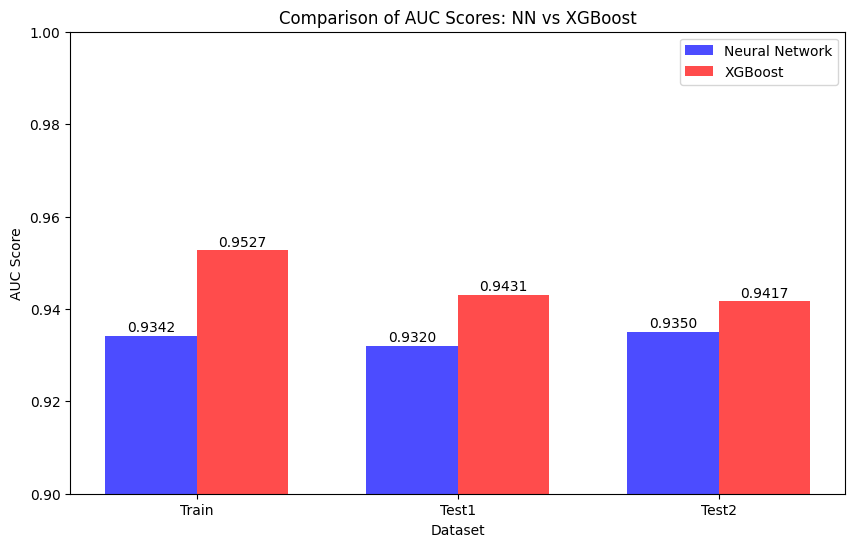

In [129]:
# Calculate AUC for NN model (Assumed to have these values)
nn_auc = [nn_train_auc, nn_test1_auc, nn_test2_auc]

# Calculate AUC for XGBoost model (Assumed to have these values)
xgb_auc = [xgb_train_auc, xgb_test1_auc, xgb_test2_auc]

# Dataset labels
datasets = ['Train', 'Test1', 'Test2']

# Bar positions
x = np.arange(len(datasets))  # Label locations
width = 0.35  # Width of bars

# Plot bars
fig, ax = plt.subplots(figsize=(10, 6))

# Neural Network Bars (Blue)
bars1 = ax.bar(x - width/2, nn_auc, width, label='Neural Network', color='blue', alpha=0.7)

# XGBoost Bars (Red)
bars2 = ax.bar(x + width/2, xgb_auc, width, label='XGBoost', color='red', alpha=0.7)

# Labels & Title
ax.set_xlabel("Dataset")
ax.set_ylabel("AUC Score")
ax.set_title("Comparison of AUC Scores: NN vs XGBoost")
ax.set_xticks(x)
ax.set_xticklabels(datasets)
ax.set_ylim(0.9, 1.0)  # Adjust y-axis based on AUC values
ax.legend()

# Show values on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', fontsize=10)
